# Introduction

In this notebook, we present the implementation and the empirical study of 'L-SAGA' : our proposed learning hyper-heuristic for the flowhsop permutation problem (FPP). It uses a simulated annealing algorithm for the top level equipped with a novel add-on learning component, and an adaptation of the genetic algorithm for the FPP for the bottom level.

The implementation code is first presented, then tested on each of the taillard instances benchmark.

Dependencies

In [44]:
import numpy as np
import pandas as pd
import optuna
import copy
import random
import math
import heuristics
from tqdm import tqdm
from matplotlib import pyplot as plt
import os
import datetime
import time

Class to hold a taillard instance

In [2]:
class Inst:
    def __init__(self, jobs: int, machines: int, seed: int, ub: int, lb: int, matrix: list[list[int]]):
        """
        Represents an instance of the scheduling problem.
        
        Args:
            jobs (int): Number of jobs.
            machines (int): Number of machines.
            seed (int): Seed for random number generation.
            ub (int): Upper bound.
            lb (int): Lower bound.
            matrix (list[list[int]]): Matrix representing job durations on machines.
        """
        self.jobs = jobs
        self.machines = machines
        self.seed = seed
        self.ub = ub
        self.lb = lb
        self.matrix = matrix

Function to load the instances of a taillard configuration

In [3]:
def load_tai(nb_jobs, nb_machines):
    with open(f"content/tai{nb_jobs}_{nb_machines}.txt", "r") as f:
        lines = f.readlines()

    instances: list[Inst] = []
    i = 0
    while i < len(lines):
        params = [int(e) for e in lines[i+1].split()]
        jobs = params[0]
        machines = params[1]
        seed = params[2]
        ub = params[3]
        lb = params[4]

        matrix = [[int(e) for e in line.strip().split()] for line in lines[i+3:i+3+machines]]
        instances.append(Inst(jobs, machines, seed, ub, lb, matrix))
        i+=3+machines
    
    return instances

Podium Bank data structure

In [4]:
class PodiumBank:
    def __init__(self, size=10):
        #the bank is sorted in an ascendant manner of the make span
        self.bank = list()
        self.size = size

    def insert(self, ms_hps): #make_span hyper_parameter_state tuple
            insertion_index = -1
            for i in range(len(self.bank)):
                if ms_hps[0]<self.bank[i][0]:
                    insertion_index = i
                    break
            if insertion_index != -1:
                self.bank = self.bank[:i] + [ms_hps] + self.bank[i:self.size-1]
            elif len(self.bank) < self.size:
                 self.bank.append(ms_hps)

L-SAGA implementation

In [116]:
class LSAGA:
    def __init__(self,
                 tai_inst:Inst,
                 init_type=['cds', 'palmer', 'neh', 'heuristics', 'heuristics_random', 'full_random'],
                 selection_type=['roulette', 'rank', 'elitist', 'tournament', 'random'],
                 crossover_type=['uniform', 'k_points'],
                 replacement_type=['best_all', 'parents_replaced_by_offspring', 'worst_population_replaced_by_offspring', 'best_between_parents_and_offspring', 'roulette', 'rank', 'elitist', 'tournament', 'random'],
                 population_size_mms=(20,60,10), #min_max_step
                 pool_size_mms=(0.1, 0.9, 0.1),
                 crossover_rate_mms=(0.1, 0.9, 0.1),
                 mutation_rate_mms=(0.1, 0.9, 0.1),
                 num_iterations_mms=(200, 600, 100),
                 max_stagnation_mms=(50, 200, 50),
                 k_points_mms=(0.1, 0.9, 0.1),
                 variety_degree=1,
                 num_hyper_params_neigh_window=1, #numeric hyper-parameters neighboring window size
                 cat_neigh_ratio=0.4,
                 podium_banck_size=10,
                ):
        self.tai_inst = tai_inst
        self.jobs_list = self.get_instance(tai_inst)
        self.nb_jobs = len(self.jobs_list)
        self.nb_machines = len(self.jobs_list[0])
        self.hps_star = None
        self.seq_star = None
        self.make_span_star = None
        self.hyper_params = {
            'init_type': init_type,
            'selection_type': selection_type,
            'crossover_type': crossover_type,
            'replacement_type': replacement_type,
            'population_size': [i for i in range(population_size_mms[0], population_size_mms[1]+1, population_size_mms[2])],
            'pool_size': [pool_size_mms[0]+i*pool_size_mms[2] for i in range(int((pool_size_mms[1]-pool_size_mms[0])/pool_size_mms[2])+1)],
            'crossover_rate': [crossover_rate_mms[0]+crossover_rate_mms[2]*i for i in range(int((crossover_rate_mms[1]-crossover_rate_mms[0])/crossover_rate_mms[2])+1)],
            'mutation_rate': [mutation_rate_mms[0]+mutation_rate_mms[2]*i for i in range(int((mutation_rate_mms[1]-mutation_rate_mms[0])/mutation_rate_mms[2])+1)],
            'num_iterations': [i for i in range(num_iterations_mms[0], num_iterations_mms[1]+1, num_iterations_mms[2])],
            'max_stagnation': [i for i in range(max_stagnation_mms[0],max_stagnation_mms[1]+1,max_stagnation_mms[2])],
        }
        s = set(
                [int((self.nb_jobs-1) * (0.01+i*0.01)) for i in range(10)]+ #exploring the hundredths
                [int((self.nb_jobs-1) * (k_points_mms[0]+i*k_points_mms[2])) for i in range(int((k_points_mms[1]-k_points_mms[0])/k_points_mms[2])+1)] #exploruing above tenths
            )
        s.discard(0)
        self.hyper_params['k_points'] =  list(s)
        self.cat_hyper_params = ['init_type', 'selection_type', 'crossover_type', 'replacement_type']
        self.num_hyper_params = ['population_size', 'pool_size', 'crossover_rate', 'mutation_rate', 'num_iterations', 'max_stagnation', 'k_points']
        self.variable_params = [key for key in self.hyper_params.keys() if self.hyper_params[key][0] != self.hyper_params[key][-1]]
        if variety_degree > len(self.variable_params): raise Exception("variety_degree > len(self.variable_params)")
        self.variety_degree = variety_degree
        self.num_hyper_params_neigh_window = num_hyper_params_neigh_window
        self.cat_neigh_ratio = cat_neigh_ratio
        self.podium_bank = PodiumBank(size=podium_banck_size)
        self.neh_res = heuristics.NEH(self.tai_inst)() 
        self.cds_res = heuristics.cds_heuristic(np.array(self.jobs_list)) 
        self.palmer_res = heuristics.Palmer(self.jobs_list).optim()

        #stats
        self.nb_podium_bank_usage = 0
        self.nb_deteriorations = 0
        self.nb_jumps = 0
        self.hps_star_trace = []
        self.current_make_span_trace = []


    # utility functions for the low level genetic algorithm

    def get_instance(self, tai_inst: Inst):
        # Extract the jobs list from the given instance
        
        jobs_list = []
        for i in range(len(tai_inst.matrix[0])):
            jobs_list.append([])
            for j in range(len(tai_inst.matrix)):
                jobs_list[-1].append(tai_inst.matrix[j][i])
        return jobs_list

    def cumulate(self, job: list, previous_cumul=None):
        # Calculate the cumulative completion times for a job
        
        res = [0] * len(job)
        if previous_cumul == None:
            res[0] = job[0]
            for i in range(1, len(job)):
                res[i] = res[i - 1] + job[i]
        else:
            res[0] = previous_cumul[0] + job[0]
            for i in range(1, len(job)):
                res[i] = max(res[i - 1], previous_cumul[i]) + job[i]
        return res

    def cumulate_seq(self, seq: list):
        # Calculates the cumulative time for a sequence of jobs on machines.

        cumulated = None
        for i in seq:
            cumulated = self.cumulate(self.jobs_list[i], cumulated)
        return cumulated

    def evaluate_makespan(self, schedule):
        # Evaluates the makespan (completion time) of a given schedule.

        cumulative = self.cumulate_seq(schedule)
        return cumulative[-1]
 
    def initialize_population(self, init_type, population_size, preced_pop):
        """
        Initializes the population of individuals.
        
        Args:
            init_type (str): Type of initialization method.
            population_size (int): Size of the population.
            
        Returns:
            list: Initialized population of individuals.
        """
        
        def perturb_sequence(sequence):
            """
            Perturbs a sequence by swapping two random jobs.
            
            Args:
                sequence (list): Sequence of jobs.
                
            Returns:
                list: Perturbed sequence.
            """
            perturbed_seq = sequence[:]
            for _ in range(2):
                i, j = random.sample(range(len(perturbed_seq)), 2)
                perturbed_seq[i], perturbed_seq[j] = perturbed_seq[j], perturbed_seq[i]
            return perturbed_seq

        population = []
        
        if init_type == "cds":
            cds_seq, _ = self.cds_res#heuristics.cds_resheuristic(np.array(self.jobs_list))
            population.append(cds_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(cds_seq)
                population.append(perturbed_seq)

        elif init_type == "palmer":
            palmer_seq, _ = self.palmer_res#heuristics.Palmer(self.jobs_list).optim()
            population.append(palmer_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(palmer_seq)
                population.append(perturbed_seq)

        elif init_type == "neh":
            _, neh_seq = self.neh_res#heuristics.NEH(self.tai_inst)()
            population.append(neh_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(neh_seq)
                population.append(perturbed_seq)

        elif init_type == "heuristics":
            cds_size = population_size // 3
            palmer_size = population_size // 3
            neh_size = population_size - cds_size - palmer_size
            
            for _ in range(cds_size):
                cds_seq, _ = self.cds_res#heuristics.cds_heuristic(np.array(self.jobs_list))
                population.append(perturb_sequence(cds_seq))
            
            for _ in range(palmer_size):
                palmer_seq, _ = self.palmer_res#heuristics.Palmer(self.jobs_list).optim()
                population.append(perturb_sequence(palmer_seq))
            
            for _ in range(neh_size):
                _, neh_seq = self.neh_res#heuristics.NEH(self.tai_inst)()
                population.append(perturb_sequence(neh_seq))

        elif init_type == "heuristics_random":

            cds_seq, _ = self.cds_res#heuristics.cds_heuristic(np.array(self.jobs_list))
            population.append(perturb_sequence(cds_seq))

            palmer_seq, _ = self.palmer_res#heuristics.Palmer(self.jobs_list).optim()
            population.append(perturb_sequence(palmer_seq))

            _, neh_seq = self.neh_res#heuristics.NEH(self.tai_inst)()
            population.append(perturb_sequence(neh_seq))

            for _ in range(population_size - 3):
                random_seq = random.sample(range(self.nb_jobs), self.nb_jobs)
                population.append(random_seq)

        elif init_type == "full_random":

            for _ in range(population_size):
                random_seq = random.sample(range(self.nb_jobs), self.nb_jobs)
                population.append(random_seq)

        else:
            raise ValueError("Invalid initialization type")
        
        if preced_pop != None:
            preced_pop_size = int(population_size * self.retention_factor)
            preced_pop = random.sample(preced_pop, k=preced_pop_size)
            new_pop_size = population_size - preced_pop_size
            new_pop = random.sample(population, k=new_pop_size)
            population = preced_pop + new_pop

        return population
  
    def select_parents(self, population):
        """
        Selects parents from the population using tournament selection.
        
        Args:
            population (list): Population of individuals.
            
        Returns:
            tuple: Pair of selected parents.
        """
        tournament = random.sample(population, 3)
        tournament.sort(key=lambda x: self.evaluate_makespan(x))
        return tournament[0], tournament[1]
  
    def crossover(self, crossover_type, parent1, parent2, crossover_rate, k_points=None):
        """
        Performs crossover between two parents to produce offspring.
        
        Args:
            crossover_type (str): Type of crossover operation.
            parent1 (list): First parent.
            parent2 (list): Second parent.
            crossover_rate (float): Rate of crossover.
            k (int, optional): Parameter for k-point crossover. Defaults to None.
            
        Returns:
            tuple: Pair of offspring.
        """

        def ensure_each_job_once(offspring):
            """
            Ensures each job appears exactly once in the offspring.
            
            Args:
                offspring (list): Offspring sequence.
            """
            # Ensure offspring contains each job exactly once
            job_count = {job: 0 for job in range(self.nb_jobs)}
            for job in offspring:
                job_count[job] += 1
            for i, job in enumerate(offspring):
                if job_count[job] > 1:
                    for swap_job, count in job_count.items():
                        if count == 0:
                            offspring[i] = swap_job
                            job_count[swap_job] += 1
                            job_count[job] -= 1
                            break

        if random.random() < crossover_rate:
            
            if crossover_type == 'uniform':
                k = None
                mask = [random.choice([0, 1]) for _ in range(len(parent1))]
                offspring1 = [gene1 if bit else gene2 for gene1, gene2, bit in zip(parent1, parent2, mask)]
                offspring2 = [gene1 if bit else gene2 for gene1, gene2, bit in zip(parent2, parent1, mask)]

            else:
                if k_points is None or k_points < 1:
                    raise ValueError("k must be >= 1 for one_point, two_points, and k_points crossovers")
                
                if k_points is not None and k_points >= self.nb_jobs:
                    raise ValueError("k in crossover must be less than the number of jobs")

                if ((crossover_type == 'one_point') or (k_points == 1)):
                    k = 1
                    points = [random.randint(1, len(parent1) - 1)]

                elif ((crossover_type == 'two_points') or (k_points == 2)):
                    k = 2
                    points = sorted(random.sample(range(1, len(parent1)), 2))

                elif crossover_type == 'k_points':
                    points = sorted(random.sample(range(1, len(parent1)), k_points))

                else:
                    raise ValueError("Invalid crossover type")

                offspring1, offspring2 = parent1[:], parent2[:]
                switch = False
                for i in range(len(parent1)):
                    if i in points:
                        switch = not switch
                    if switch:
                        offspring1[i], offspring2[i] = offspring2[i], offspring1[i]

            ensure_each_job_once(offspring1)
            ensure_each_job_once(offspring2)
            return offspring1, offspring2
        
        else:
            return parent1[:], parent2[:]

    def mutate(self, solution, mutation_rate):
        """
        Mutates a solution with a given mutation rate.
        
        Args:
            solution (list): Solution to mutate.
            mutation_rate (float): Rate of mutation.
            
        Returns:
            list: Mutated solution.
        """
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(solution)), 2)
            solution[i], solution[j] = solution[j], solution[i]
        return solution

    def select_reproduction_pool(self, selection_type, population, pool_size):
        """
        Selects a pool of individuals for reproduction.
        
        Args:
            selection_type (str): Type of selection method.
            population (list): Population of individuals.
            pool_size (int): Size of the pool.
            
        Returns:
            list: Pool of selected individuals.
        """
        
        chosen = []

        if selection_type == "roulette":
            total_fitness = sum(self.evaluate_makespan(ind) for ind in population)
            selection_probs = [self.evaluate_makespan(ind) / total_fitness for ind in population]
            chosen = random.choices(population, weights=selection_probs, k=pool_size)

        elif selection_type == "rank":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            ranks = range(1, len(population_sorted) + 1)
            total_rank = sum(ranks)
            rank_weights = [rank / total_rank for rank in ranks]
            chosen = random.choices(population_sorted, weights=rank_weights, k=pool_size)

        elif selection_type == "elitist":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            chosen = population_sorted[:pool_size]

        elif selection_type == "tournament":
            for _ in range(pool_size):
                contenders = random.sample(population, 3)
                chosen.append(min(contenders, key=self.evaluate_makespan))

        elif selection_type == "random":
            chosen = random.sample(population, pool_size)
            
        else:
            raise ValueError("Invalid type")

        return chosen
  
    def replace_population(self, replacement_type, population, parents, offspring, population_size):
        """
        Replaces the population with new individuals.
        
        Args:
            replacement_type (str): Type of replacement method.
            population (list): Current population.
            parents (list): Parents generated during reproduction.
            offspring (list): Offspring generated during reproduction.
            population_size (int): Size of the population.
            
        Returns:
            list: New population.
        """
        
        def select_population(selection_type, population, pool_size):
            """
            Selects individuals for the next population.
            
            Args:
                selection_type (str): Type of selection method.
                population (list): Population of individuals.
                pool_size (int): Size of the selection pool.
                
            Returns:
                list: Selected individuals for the next population.
            """
            return self.select_reproduction_pool(selection_type, population, pool_size)

        if replacement_type == "best_all":
            combined_population = population + offspring
            combined_population.sort(key=lambda x: self.evaluate_makespan(x))
            return combined_population[:population_size]

        elif replacement_type == "parents_replaced_by_offspring":
            population_without_parents = [ind for ind in population if ind not in parents]
            return population_without_parents + offspring

        elif replacement_type == "worst_population_replaced_by_offspring":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            population_without_worst = population_sorted[:-len(offspring)]
            return population_without_worst + offspring

        elif replacement_type == "best_between_parents_and_offspring":
            population_without_parents = [ind for ind in population if ind not in parents]
            combined_sub_population = sorted(parents + offspring, key=self.evaluate_makespan)
            return population_without_parents + combined_sub_population[:len(parents)]
        
        else:
            return select_population(replacement_type, population + offspring, len(population))

    def genetic_algorithm(self, init_type, selection_type, crossover_type, replacement_type, population_size, pool_size, crossover_rate, mutation_rate, num_iterations, max_stagnation, k_points=None, preced_pop=None):
        """
        Executes the Genetic Algorithm to find the best solution.
        
        Args:
            init_type (str): Type of initialization method.
            selection_type (str): Type of parent selection method.
            crossover_type (str): Type of crossover method.
            replacement_type (str): Type of population replacement method.
            population_size (int): Size of the population.
            pool_size (int): Size of the reproduction pool.
            crossover_rate (float): Rate of crossover.
            mutation_rate (float): Rate of mutation.
            num_iterations (int): Maximum number of iterations.
            max_stagnation (int): Maximum number of iterations without improvement.
            k_points (int, optional): Parameter for k-point crossover. Defaults to None.
            
        Returns:
            tuple: Best solution and its makespan.
        """
        
        if pool_size > population_size:
            raise ValueError("Pool size must be less than population size.")

        population = self.initialize_population(init_type, population_size, preced_pop=preced_pop)
        population.sort(key=lambda x: self.evaluate_makespan(x))
        
        best_solution = population[0]
        best_solution_fitness = self.evaluate_makespan(best_solution)
        stagnation_count = 0

        for i in range(num_iterations):
            reproduction_pool = self.select_reproduction_pool(selection_type, population, pool_size)
            offspring = []
            parents = []

            for _ in range(pool_size // 2):
                parent1, parent2 = self.select_parents(reproduction_pool)
                parents.extend([parent1, parent2])
                child1, child2 = self.crossover(crossover_type, parent1, parent2, crossover_rate, k_points) 
                child1 = self.mutate(child1, mutation_rate)
                child2 = self.mutate(child2, mutation_rate)
                offspring.extend([child1, child2])

            population = self.replace_population(replacement_type, population, parents, offspring, population_size)
            population.sort(key=lambda x: self.evaluate_makespan(x))

            current_best_solution = population[0]
            current_best_solution_fitness = self.evaluate_makespan(current_best_solution)

            if current_best_solution_fitness < best_solution_fitness:
                best_solution = current_best_solution
                best_solution_fitness = current_best_solution_fitness
                stagnation_count = 0
            else:
                stagnation_count += 1

            if max_stagnation is not None and stagnation_count >= max_stagnation:
                break

        return best_solution, population

    # utility functions for the high level simulated annealing

    def init_random_hps(self):
        hps={
            'init_type':np.random.choice(self.hyper_params['init_type']),
            'selection_type':np.random.choice(self.hyper_params['selection_type']),
            'crossover_type':np.random.choice(self.hyper_params['crossover_type']),
            'replacement_type':np.random.choice(self.hyper_params['replacement_type']),
            'population_size':np.random.choice(self.hyper_params['population_size']),
            'pool_size':np.random.choice(self.hyper_params['pool_size']),
            'crossover_rate':np.random.choice(self.hyper_params['crossover_rate']),
            'mutation_rate':np.random.choice(self.hyper_params['mutation_rate']),
            'num_iterations':np.random.choice(self.hyper_params['num_iterations']),
            'max_stagnation':np.random.choice(self.hyper_params['max_stagnation']),
            'k_points':np.random.choice(self.hyper_params['k_points'])
        }
        return hps
    
    def cartesian_product(self, possible_values, keys): #the list of possible values for each dimension
        products = [{keys[0]:value} for value in possible_values[0]]
        for dimension_values, key in zip(possible_values[1:], keys[1:]):    
            new_products = []
            for product in products:
                for value in dimension_values:
                    new_product = dict(product)
                    new_product[key] = value
                    new_products.append(new_product)
            products = new_products
        return products

    def measure_hps_dist(self, hps1, hps2):
        dist = 0
        for hyper_param in self.cat_hyper_params:
            dist +=  (1 if hps1[hyper_param] == hps2[hyper_param] else 0) # * relevance_coeff ...! 
        for hyper_param in self.num_hyper_params:
            if hyper_param not in self.variable_params: continue
            dist += abs(hps1[hyper_param] - hps2[hyper_param]) / (self.hyper_params[hyper_param][-1] - self.hyper_params[hyper_param][0]) # * relevance_coeff ...!
        return dist

    def get_podium_score(self,neigh):
        score = 0
        tot_podium_make_spans = sum([1/(ms_champion[0]) for ms_champion in self.podium_bank.bank])
        for make_span, champion in self.podium_bank.bank:
            score += math.exp(-self.measure_hps_dist(neigh, champion)) * ((1/(make_span))/tot_podium_make_spans)
        return score

    def generate_neigh_hps(self, hps, T, beta):
        #randomly selecting 'self.variety_degree' hyper_parameters to forcibly vary, the rest of the hyper_params can either vary or not
        varied_keys = np.random.choice([key for key in self.variable_params], self.variety_degree, replace=False)
        #we create the neighbor hps possible values for each hyper parameter
        neigh_hps_values = []
        #for each categorical hyper-param
        for hyper_param in self.cat_hyper_params:
            #if the hyper param is to be forcibly varied
            if hyper_param in varied_keys:
                neigh_space = list(self.hyper_params[hyper_param])
                neigh_space.remove(hps[hyper_param])
                neigh_hps_values.append(np.random.choice(neigh_space, int(self.cat_neigh_ratio * len(neigh_space)+1), replace=False))
            else:
                neigh_hps_values.append(np.random.choice(self.hyper_params[hyper_param], int(self.cat_neigh_ratio * len(self.hyper_params[hyper_param]))+1, replace=False))
        #for each numercial hyper-param
        for hyper_param in self.num_hyper_params:
            # we get its index in the range of possible values
            hyper_param_value_index = self.hyper_params[hyper_param].index(hps[hyper_param])
            # we get the bottom index of the neighboring window using self.num_hyper_param_neigh_windows
            win_bottom_index = hyper_param_value_index-self.num_hyper_params_neigh_window
            # we check if we didn't go below 0
            if win_bottom_index < 0: win_bottom_index = 0
            # we create the neighboring space
            neigh_space = self.hyper_params[hyper_param][win_bottom_index : hyper_param_value_index+self.num_hyper_params_neigh_window+1]
            if hyper_param in varied_keys:
                neigh_space.remove(hps[hyper_param])
                neigh_hps_values.append(neigh_space)
            else:
                neigh_hps_values.append(neigh_space)

        #we check if the temperature is still high ==> we are still in full exploration
        if ( self.podium_bank.size == 0 ) or ( np.random.random() < math.exp(-(1/(beta*T))) ):
            neighbor = {key:np.random.choice(neigh_hps_values[i]) for i, key in enumerate(self.hyper_params.keys())}
            #neighbor = random.sample(neighbors, 1)[0]
        #else we use the podium
        else:
            self.nb_podium_bank_usage += 1
            #we generate all the possible neighbors by doing the cartesian product of the neigh values for the different dimensions 
            neighbors = self.cartesian_product(neigh_hps_values, self.cat_hyper_params + self.num_hyper_params)
            #we affect podium scores to the neighbors
            neigh_podium_scores = []
            for neigh in neighbors:
                neigh_podium_scores.append(self.get_podium_score(neigh))
            #we randomly select the new neighbor using the podium_scores as weights
            p = np.array(neigh_podium_scores)
            p = p / np.sum(p)
            neighbor = np.random.choice(neighbors, p=p)
        return neighbor

    def optim(self,
              T=1.0,
              T_min=0.001,
              alpha=0.9, #decay factor
              beta=10, #exploration factor
              nb_iter=100,
              length_palier=1,
              jump_rate=0,
              jump_ratio=1,
              max_stag=15,
              retention_factor=0.05,
              debug=False,
              trace=False
            ):
        #initializing the hyper_parameter_state hps randomly and computing the corresponding make_span_star
        self.retention_factor = retention_factor
        loc_hps_star = hps = self.init_random_hps()
        ga_params = dict(hps)
        ga_params['pool_size'] = int(ga_params['pool_size'] * ga_params['population_size'])
        if (ga_params['pool_size']<=2) : ga_params['pool_size'] = 3
        print(f"Executing initial GA with {ga_params['num_iterations']} iterations")
        current_seq, population = self.genetic_algorithm(**ga_params, preced_pop=None)
        loc_seq_star = current_seq
        loc_make_span_star = current_make_span = old_make_span = self.evaluate_makespan(current_seq)
        #inserting the first hps in the podium bank
        self.podium_bank.insert((current_make_span, hps))
        #showing some debug
        if debug:
            print('initial hps', hps)
            print('initial make_span', current_make_span)
        #preping the tracing
        if trace:
            self.hps_star_trace.append(loc_hps_star)
            self.current_make_span_trace.append(current_make_span)
        #we initialize the temperature session at length_palier
        temp_session = length_palier
        stag_counter = 0 # stagnation counter, once it reaches max_stag, the algorithm stops
        self.left_of_stagnation = False
        #main loop
        for _ in (t := tqdm(range(nb_iter))):
            #generate a random neighbour sequence
            new_hps = self.generate_neigh_hps(hps, T, beta)
            #compute the energy difference
            ga_params = dict(new_hps)
            ga_params['pool_size'] = int(ga_params['pool_size'] * ga_params['population_size'])
            t.set_description(f"Temperature {T}, GA {ga_params['num_iterations'] } iters")
            if (ga_params['pool_size']<=2) : ga_params['pool_size'] = 3
            neigh_seq, population = self.genetic_algorithm(**ga_params,preced_pop=population)
            neigh_make_span = self.evaluate_makespan(neigh_seq)
            # delta = current_make_span - neigh_make_span
            delta = (current_make_span - neigh_make_span) / (current_make_span - self.tai_inst.lb)
            # if the neighbour sequence is better, accept it
            if delta > 0:
                hps = new_hps
                current_seq = neigh_seq
                current_make_span = neigh_make_span
                #we insert the new hps and its makespan into the podium bank
                self.podium_bank.insert((current_make_span, hps))
                # we check if the newly obtained solution is better than the current best
                if current_make_span < loc_make_span_star:
                    loc_hps_star = hps
                    loc_seq_star = current_seq
                    loc_make_span_star = current_make_span
                    if trace:
                        self.hps_star_trace.append(loc_hps_star)
            #if the neighbour sequence is worse, accept it with a probability that decreases with the temperature
            elif np.random.random() < math.exp(delta/(T)):
                    self.nb_deteriorations += 1
                    hps = new_hps
                    current_seq = neigh_seq
                    current_make_span = neigh_make_span
                    #we insert the new hps and its makespan into the podium bank
                    self.podium_bank.insert((current_make_span, hps))
            #cooling
            temp_session -= 1
            if temp_session == 0:
                if np.random.random() < jump_rate:
                    self.nb_jumps += 1
                    T = T * jump_ratio
                else:
                    T = T * alpha
                temp_session = length_palier
            if(T<=T_min): break
            #checking for stagnation
            if (current_make_span == old_make_span):
                stag_counter += 1
                if stag_counter == max_stag:
                    self.left_of_stagnation = True
                    break
            else:
                stag_counter = 0    
            old_make_span = current_make_span 
            if trace:
                self.current_make_span_trace.append(current_make_span)
        self.hps_star = loc_hps_star
        self.seq_star = loc_seq_star
        self.make_span_star = loc_make_span_star 

Demo

Executing initial GA with 400 iterations


Temperature 0.062291452021081634, GA 600 iters:  55%|█████▍    | 93/170 [05:38<04:40,  3.64s/it]

make_span_star 1286
hps_star {'init_type': 'palmer', 'selection_type': 'tournament', 'crossover_type': 'k_points', 'replacement_type': 'best_between_parents_and_offspring', 'population_size': 50, 'pool_size': 0.9, 'crossover_rate': 0.30000000000000004, 'mutation_rate': 0.5, 'num_iterations': 200, 'max_stagnation': 200, 'k_points': 5}
nb_podium_bank_usage 7
nb_deteriorations 67
nb_jumps 2
left_of_stagnation True


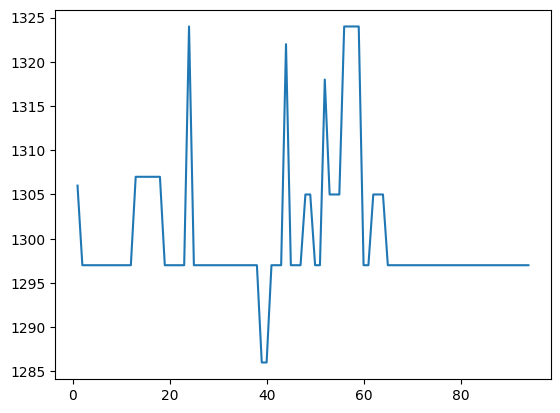

In [103]:
random.seed()
tai_inst = load_tai(20, 5)
hh = LSAGA(tai_inst[0],
           variety_degree=5,
           num_hyper_params_neigh_window=2, #numeric hyper-parameters neighboring window size
           cat_neigh_ratio=0.4,
           podium_banck_size=5)
hh.optim(T=1,
         T_min=0.008,
         alpha=0.9, # decay factor
         beta=100, # exploration factor
         nb_iter=170,
         length_palier=3,
         jump_rate=0.05,
         jump_ratio=1.15,
         max_stag=30,
         trace=True
        )
print('make_span_star', hh.make_span_star)
print('hps_star', hh.hps_star)
print('nb_podium_bank_usage', hh.nb_podium_bank_usage)
print('nb_deteriorations', hh.nb_deteriorations)
print('nb_jumps', hh.nb_jumps)
print('left_of_stagnation', hh.left_of_stagnation)
plt.plot(range(1, len(hh.current_make_span_trace)+1), hh.current_make_span_trace)

function to test lsaga on taillard benchmarks

In [129]:
def execute_lsaga(nb_jobs, nb_machines, nb_execs=3):
  date_time = datetime.datetime.now()
  results_file_path = f'results/tai{nb_jobs}_{nb_machines}/{date_time.year}_{date_time.month}_{date_time.day}_{date_time.hour}_{date_time.minute}_{date_time.second}.txt'
  os.makedirs(os.path.dirname(results_file_path), exist_ok=True)
  with open(results_file_path, 'a') as f:
      f.write(f'nb_execs_per_instance: {nb_execs}\n\n\n')
  instances = load_tai(nb_jobs, nb_machines)
  for num_inst, instance in enumerate(instances):
    print('INSTANCE:', num_inst+1)
    mean_make_span = 0
    min_make_span = float('infinity')
    with open(results_file_path, 'a') as f:
      f.write(f'num_inst: {num_inst+1}\n\n')
    lsaga = LSAGA(instance,
                  variety_degree=5,
                  num_hyper_params_neigh_window=2, #numeric hyper-parameters neighboring window size
                  cat_neigh_ratio=0.4,
                  podium_banck_size=5,
                )
    for exec in range(nb_execs):
      random.seed()
      np.random.seed()
      print("===> EXEC:", exec+1)
      t_init = time.time()
      t_optim = time.time()
      lsaga.optim(T=1,
                  T_min=0.008,
                  alpha=0.9, # decay factor
                  beta=100, # exploration factor
                  nb_iter=170,
                  length_palier=3,
                  jump_rate=0.05,
                  jump_ratio=1.15,
                  max_stag=40,
                  trace=True)
      t_finish = time.time()
      mean_make_span += lsaga.make_span_star
      if lsaga.make_span_star < min_make_span:
        min_make_span = lsaga.make_span_star
      with open(results_file_path, 'a') as f:
        f.write(f'seq_star: {lsaga.seq_star}\n')
        f.write(f'make_span_star: {lsaga.make_span_star}\n')
        f.write(f'hps_star: {lsaga.hps_star}\n')
        f.write(f'hps_star_trace: {lsaga.hps_star_trace}\n')
        f.write(f'current_make_span_trace: {lsaga.current_make_span_trace}\n')
        f.write(f'podium_bank: {lsaga.podium_bank.bank}\n')
        f.write(f'nb_podium_bank_usage: {lsaga.nb_podium_bank_usage}\n')
        f.write(f'nb_deteriorations: {lsaga.nb_deteriorations}\n')
        f.write(f'nb_jumps: {lsaga.nb_jumps}\n')
        f.write(f'left_of_stagnation: {lsaga.left_of_stagnation}\n')
        f.write(f'execution_time_with_init: {t_finish-t_init}\n')
        f.write(f'execution_time_without_init: {t_finish-t_optim}\n')
        f.write('\n')
    with open(results_file_path, 'a') as f:
      f.write(f'min_make_span: {min_make_span}\n')
      f.write(f'mean_make_span: {mean_make_span/nb_execs}\n')
      f.write(f'num_inst: {num_inst+1}\n\n\n')
    print('\n\n')

# Algorithm execution

20 jobs 5 machines

In [ ]:
execute_lsaga(20, 5)

20 jobs 10 machines

In [ ]:
execute_lsaga(20, 10)

20 jobs 20 machines

In [ ]:
execute_lsaga(20, 20)

50 jobs 5 machines

In [ ]:
execute_lsaga(50, 5)

50 jobs 10 machines

In [ ]:
execute_lsaga(50, 10)

50 jobs 20 machines

In [ ]:
execute_lsaga(50, 20)

100 jobs 5 machines

In [ ]:
execute_lsaga(100, 5)

100 jobs 10 machines

In [ ]:
execute_lsaga(100, 10)

200 jobs 10 machines

In [ ]:
execute_lsaga(200, 10)

200 jobs 20 machines

In [ ]:
execute_lsaga(200, 20)

500 jobs 20 machines

In [ ]:
execute_lsaga(500, 20)